submitted by: Francine Borromeo

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
file_path = "C:/Users/FREDDIE/Downloads/seoul+bike+sharing+demand/SeoulBikeData.csv"
seoul_bike_data = pd.read_csv(file_path, encoding='latin1')
bike_data = pd.read_csv(file_path, encoding='cp949')

Data Exploration

TASK: Create a correlation heatmap.

c:\Users\FREDDIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 52892 (\N{HANGUL SYLLABLE KAELS}) missing from current font.
  fig.canvas.draw()
c:\Users\FREDDIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52892 (\N{HANGUL SYLLABLE KAELS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


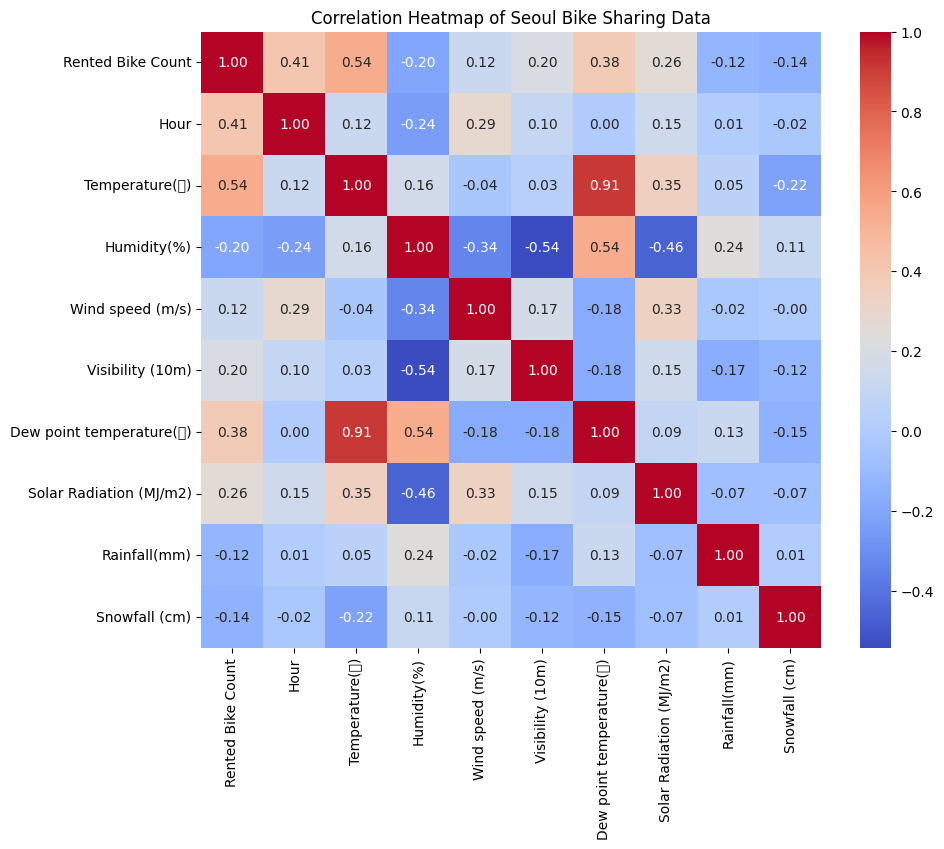

In [7]:
# Exclude non-numeric columns
numeric_columns = bike_data.select_dtypes(include=['int64', 'float64'])

# Create correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Seoul Bike Sharing Data')
plt.show()




TASK: What are the top 5 correlated frequencies with the target\label?

Note: You many need to map the label to 0s and 1s.

Additional Note: We're looking for absolute correlation values.

In [10]:
# Exclude non-numeric columns
numeric_columns = bike_data.select_dtypes(include=['int64', 'float64'])

# Map the label to 0s and 1s
bike_data['Mapped_Label'] = bike_data['Rented Bike Count'].apply(lambda x: 1 if x > bike_data['Rented Bike Count'].mean() else 0)

# Calculate absolute correlations between the label and other features
correlations = numeric_columns.corrwith(bike_data['Mapped_Label'].abs()).abs().sort_values(ascending=False)

# Exclude the label itself
correlations = correlations.drop('Mapped_Label')

# Select the top 5 correlated features
top_correlations = correlations.head(5)

print("Top 5 correlated frequencies with the target label:")
print(top_correlations)

Top 5 correlated frequencies with the target label:
Rented Bike Count           0.822313
Temperature(캜)              0.528774
Dew point temperature(캜)    0.374003
Solar Radiation (MJ/m2)     0.358700
Hour                        0.350299
dtype: float64


Train | Test Split
Our approach here will be one of using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate our model.

TASK: Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.

In [11]:
# Split the data into features and labels
X = numeric_columns.drop('Mapped_Label', axis=1)  # Features
y = bike_data['Mapped_Label']  # Label

# Split the data into a training set (90%) and a test set (10%)
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Cross-Validation: Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_cv, y_train_cv, test_size=0.1, random_state=42)

# Print the shapes of the resulting sets
print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of validation set:", X_val.shape, y_val.shape)
print("Shape of test set:", X_test.shape, y_test.shape)

Shape of training set: (7095, 10) (7095,)
Shape of validation set: (789, 10) (789,)
Shape of test set: (876, 10) (876,)


TASK: Create a PipeLine that contains both a StandardScaler and a KNN model

In [14]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler
    ('knn', KNeighborsClassifier())  # Step 2: KNN Classifier
])

TASK: Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.

In [16]:
# Define the parameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],  # Test various values of k
    # You can add more hyperparameters to search over if needed
    # 'knn__metric': ['euclidean', 'manhattan'],
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # 5-fold cross-validation

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Report the best performing parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'knn__n_neighbors': 5}


(HARD) TASK: Using the .cv_results_ dictionary, see if you can create a plot of the mean test scores per K value.

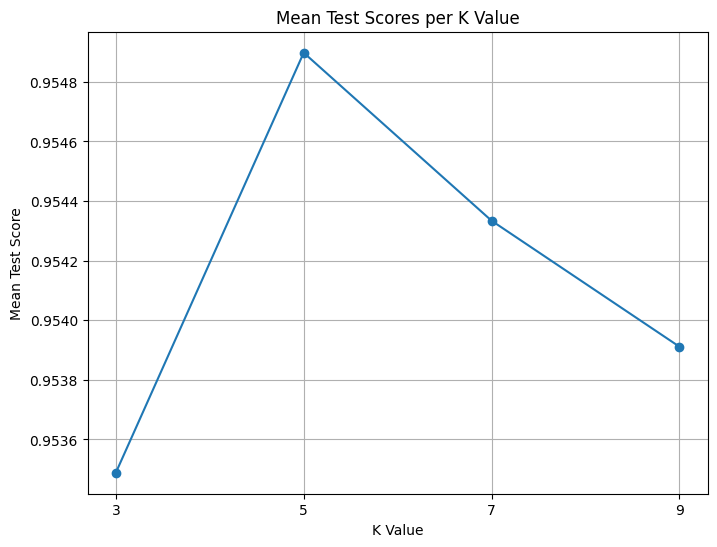

In [17]:
# Extract mean test scores and corresponding values of k
mean_test_scores = grid_search.cv_results_['mean_test_score']
k_values = param_grid['knn__n_neighbors']

# Plot mean test scores per K value
plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_test_scores, marker='o', linestyle='-')
plt.title('Mean Test Scores per K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Test Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Final Model Evaluation
TASK: Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.

In [19]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Predict labels for the test set
y_pred = best_estimator.predict(X_test)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       531
           1       0.94      0.92      0.93       345

    accuracy                           0.95       876
   macro avg       0.94      0.94      0.94       876
weighted avg       0.95      0.95      0.95       876

Confusion Matrix:
[[509  22]
 [ 26 319]]
